# Consistency between the raster and vector versions of the Randolph Glacier Inventory (RGI) for year 2000 dataset in the context of glaciological and hydrological applications

Production date: 17-07-2024

Update: 26-01-2025

Dataset version: 6.0

Produced by: Yoni Verhaegen and Philippe Huybrechts (Vrije Universiteit Brussel)

## 🌍 Use case: Assessing the spatial distribution of glaciers and the total glacier area in the context of water resource management at the local, regional, and global scale

## ❓ Quality assessment question
* **"How do glacier areas calculated from vector data compare to those calculated from the raster version of the data, and what does this comparison reveal about the quality and consistency of the glacier extent dataset?"**

Glaciers are a major contributor to current global sea-level rise, a resource of fresh water, a potential threat of natural hazards, and an important factor for hydro-power production and runoff, as well as for recreation and tourism. A proper assessment of glacier areas, glacier characteristics, as well as their changes due to warming climatic conditions therefore plays a crucial role in dealing with these issues. In that regard, the "[Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview)" (here we use version 6.0) dataset on the Climate Data Store (CDS) provides key information with respect to glacier extent and their characteristics. The RGI dataset is a collection of digital glacier and ice cap outlines at the global scale, nominally provided for the year 2000 CE [[1](https://www.glims.org/RGI/randolph60.html), [2](https://www.cambridge.org/core/journals/journal-of-glaciology/article/randolph-glacier-inventory-a-globally-complete-inventory-of-glaciers/730D4CC76E0E3EC1832FA3F4D90691CE)]. The data are available in both vector (a shapefile with polygons of individual glacier outlines) and raster (as gridded data with the aggregated fractional glacier areas per pixel) format. As it is the most complete dataset of glacier extent data with a global coverage, researchers often take this data to represent the current state of all glaciers. This notebook investigates the dataset's consistency by comparing the total regional and global glacier surface area between the vector (polygons) and raster (gridded data) version of the data. 

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
- The RGI v6.0 dataset, available on the Climate Data Store, is the most comprehensive global dataset for glacier outlines around the year 2000 CE, offering both vector (polygon) and raster (gridded) formats. While both formats are suitable for visualizing and quantifying glacier areas at local, regional, and global scales, the raster data requires users to calculate absolute glacier areas from fractional values (without the corresponding absolute surface area of a certain grid cell provided). Furthermore, notable discrepancies between the two formats exist, particularly in RGI regions 14 and 15 (South Asia West and East), where significant differences exist between the total glacierized area of the raster and vector products. These differences affect the quality, internal consistency, and reliability of the data, for example in the context of the specific use case of this notebook (i.e. for the purpose of water resource management).
- Additional limitations include the dataset’s single temporal snapshot (which makes it hence unsuitable for temporal or climate change assessments), inconsistencies in digitization dates, and poor-quality outlines in some regions (e.g. debris-covered glaciers or areas with shadow artifacts). When using the data as input for the purpose of water resource management at the local, regional or global scale, the discrepancies between glacier areas from the vector and raster format of the dataset, together with other potential limitations, have to be taken into account. Users must account for these issues and, if necessary, validate glacier areas with external sources (e.g. remote sensing data form other satellite missions or time periods) for accurate use in hydrological, glaciological, or climatological applications.
```

## 📋 Methodology

### Dataset description

The dataset of the glaciers distribution on the Climate Data Store (CDS) is an almost complete collection of digital glacier and ice cap outlines and their geometrical/hypsometrical characteristics from various data sources at the global scale [[1](https://www.glims.org/RGI/randolph60.html), [2](https://www.cambridge.org/core/journals/journal-of-glaciology/article/randolph-glacier-inventory-a-globally-complete-inventory-of-glaciers/730D4CC76E0E3EC1832FA3F4D90691CE)]. The dataset on the CDS is considered a snapshot of glacier outlines around the year 2000 CE, assembled mainly from satellite images, and is based on the Randolph Glacier Inventory (RGI), which is currently the most complete dataset of glacier outlines. Simply stated, the glaciers in the dataset were automatically classified using the distinctive spectral reflectance signatures of snow and ice. During post-processing, raw glacier outlines are quality checked and manually corrected if required (e.g. in the case of a supraglacial debris cover). The vector part of the dataset divides the glaciers into separate RGI regions, i.e. there are 19 of those regions ("clusters" of glaciers) in RGIv6.0. The raster version of the data contains aggregated fractional glacier areas for each pixel of 1 by 1 degree but does not provide sufficient information to separate glaciers into distinct RGI regions. For a more detailed description of the data acquisition and processing methods, we refer to the [documentation on the CDS](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/display/CKB/Glacier+Area) (Copernicus Knowledge Base).

### Structure and (sub)sections

- Data preparation and processing
- Spatial distribution of glaciers and glacier area in the raster version of the dataset
- Spatial distribution of glaciers and glacier area in the vector version of the dataset
- Regional and global comparison of the vector and raster product
- Implications for use of the data for water resource management purposes at various spatial scales

## 📈 Analysis and results

### Data preparation and processing

First we load the packages:

In [1]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import seaborn as sns
import xesmf as xe
from datetime import datetime
import os
from c3s_eqc_automatic_quality_control import download
plt.style.use("seaborn-v0_8-notebook")

############### PLEASE DELETE THE LINE BELOW BEFORE PUBLICATION ###############
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")
############### PLEASE DELETE THE LINE ABOVE BEFORE PUBLICATION ###############

Then we define requests for download from the CDS and download the data. 

🚨 **The files can be large! Since the data files to be downloaded and manipulated have a considerable size, this may take a couple of minutes.**

In [22]:
print("Downloading and handling glacier extent data from the CDS, this may take a couple of minutes...")

# Glacier extent data (raster)
request_extent_gridded = (
    "insitu-glaciers-extent",
    {
        "variable": "glacier_area",
        "product_type": "gridded",
        "version": "rgi_6_0",
    },
)

# Get glacier extent gridded data
df2 = download.download_and_transform(*request_extent_gridded)
print("Download glacier extent data (raster) completed.")

print("Now for the vector data...")
# Glacier extent data (vector)
request_extent = (
    "insitu-glaciers-extent",
    {
    "variable": ["glacier_area"],
    "product_type": ["vector"],
    "version": "rgi_6_0"
    },
)

df = download.download_and_transform(*request_extent).to_pandas()
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["CENLON"], df["CENLAT"]),
    crs="EPSG:4326",
)

print("Downloading and handling glacier extent data (vector) completed.")

100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Download glacier extent data (raster) completed.
Now for the vector data...


100%|██████████| 1/1 [00:00<00:00, 26.69it/s]
                                             

Lastly, we can read and inspect the data. Let us print out the raster data to inspect its structure:

In [9]:
df2

<xarray.Dataset> Size: 249kB
Dimensions:       (latitude: 170, longitude: 360)
Coordinates:
  * longitude     (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude      (latitude) float64 1kB 84.5 83.5 82.5 ... -82.5 -83.5 -84.5
Data variables:
    Glacier_area  (latitude, longitude) float32 245kB dask.array<chunksize=(170, 360), meta=np.ndarray>
Attributes: (12/15)
    Source_Software:            Esri ArcGIS
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...
    title:                      Randolph Glacier Inventory v6 (RGI6) gridded ...
    project:                    Copernicus Climate Change Service (C3S) Essen...
    data_version:               version 6.0
    institution:                Department of Geography - University of Zuric...
    ...                         ...
    geospatial_lon_resolution:  1.0
    geospatial_lat_resolution:  1.0
    references:                 Pfeffer et al. (2014) doi.org/10.3189/2014JoG...
    citation:                   RGI Consortium (2017): Randolph Glacier Inven...
    Conventions:                CF Version CF-1.0
    comment:                    Brief data description: Temporal resolution: ...

It is a gridded dataset at a 1 by 1 degree spatial resolution containing the fractional area (in %) of a grid cell covered by glaciers in the `Glacier_area` variable (i.e. these are not absolute glacier areas). Note that not all grid cells exhibit the same absolute surface area, as grid cells get smaller towards the poles. The surface area of a grid cell is not included in the dataset.

And for the vector data:

In [10]:
df

,C3S_ID,RGIID,GLIMSID,BGNDATE,ENDDATE,CENLON,CENLAT,O1REGION,O2REGION,AREA,ZMIN,ZMAX,ZMED,SLOPE,ASPECT,LMAX,NAME,geometry
index,,,,,,,,,,,,,,,,,,
0,C3S_000001,RGI60-01.00001,G213177E63689N,20090703,-9999999,-146.8230,63.6890,1,2,0.360,1936,2725,2385,42.0,346,839,None,"POLYGON ((-146.81804 63.69081, -146.81768 63.6..."
1,C3S_000002,RGI60-01.00002,G213332E63404N,20090703,-9999999,-146.6680,63.4040,1,2,0.558,1713,2144,2005,16.0,162,1197,None,"POLYGON ((-146.66354 63.40764, -146.66344 63.4..."
2,C3S_000003,RGI60-01.00003,G213920E63376N,20090703,-9999999,-146.0800,63.3760,1,2,1.685,1609,2182,1868,18.0,175,2106,None,"POLYGON ((-146.07232 63.38348, -146.07232 63.3..."
3,C3S_000004,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.1200,63.3810,1,2,3.681,1273,2317,1944,19.0,195,4175,None,"POLYGON ((-146.14895 63.37919, -146.14881 63.3..."
4,C3S_000005,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.0570,63.5510,1,2,2.573,1494,2317,1914,16.0,181,2981,None,"POLYGON ((-147.04307 63.55024, -147.04483 63.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216424,C3S_216425,RGI60-19.02748,G322268E53986S,20020502,-9999999,-37.7325,-53.9860,19,3,0.042,310,510,-999,29.9,315,255,None,"POLYGON ((-37.73275 -53.98779, -37.73328 -53.9..."
216425,C3S_216426,RGI60-19.02749,G323864E54831S,20030207,-9999999,-36.1361,-54.8310,19,3,0.567,330,830,-999,23.6,200,1130,None,"POLYGON ((-36.13834 -54.82735, -36.13826 -54.8..."
216426,C3S_216427,RGI60-19.02750,G322698E54188S,20030207,-9999999,-37.3018,-54.1884,19,3,4.118,10,1110,-999,16.8,308,4329,None,"POLYGON ((-37.29309 -54.17506, -37.29308 -54.1..."


As can be seen above, the data includes attribute information for each individual glacier (i.e. digitized polygon) in the vector-type dataset. Important for this notebook is the `AREA` column (in km$^2$), which contain information about the absolute surface area of the specific glacier. As can already be seen, for some glaciers (part of) these data are missing and filled by `-9999999`. We will use this information below.

### Spatial distribution of glaciers and glacier area in the raster version of the dataset

#### Per-pixel fractional glacierized area

Let us check the spatial distribution of all glaciers in the dataset from the raster product. We therefore produce a world map where every grid cell represents the fractional glacier area in that specific grid cell (in %):

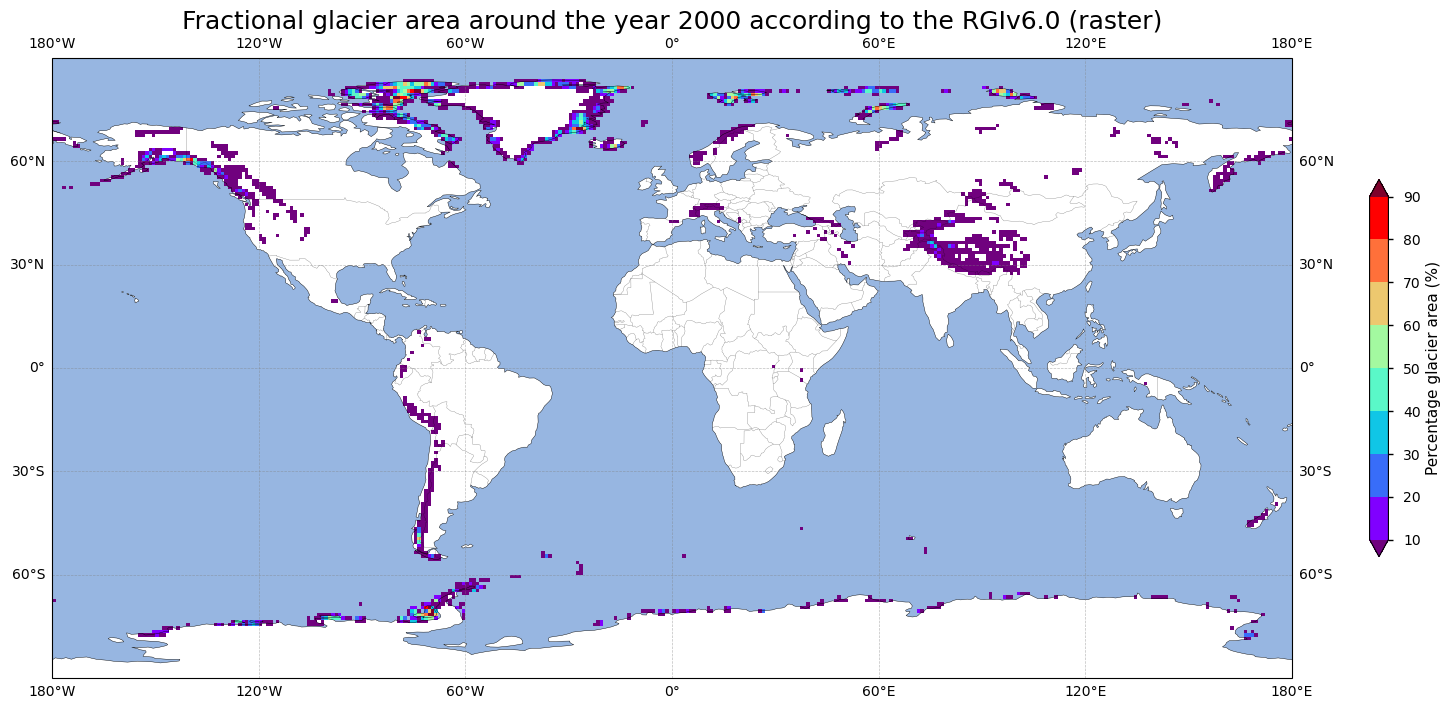

In [37]:
# Plot the gridded data
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
im=ax.pcolormesh(df2["longitude"].values, df2["latitude"].values, df2["Glacier_area"].values, transform=ccrs.PlateCarree(), cmap = mpl.cm.rainbow, norm = mpl.colors.BoundaryNorm(range(10, 100, 10), mpl.cm.rainbow.N))
im.cmap.set_over('#7E012B')
im.cmap.set_under('#70017E')
fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Percentage glacier area (%)')
plt.title('Fractional glacier area around the year 2000 according to the RGIv6.0 (raster)',fontsize=18)
plt.show()

*<center>Figure 1. Spatial distribution of the fractional glacier area in the raster version of the glacier extent dataset.</center>*

#### Per-pixel absolute glacierized area

To calculate the total absolute glacier area from the raster product, we first need to find the surface area of a 1 by 1 degree pixel across the globe, which varies for each pixel (i.e. the surface area of a pixel gets smaller towards the poles). After multiplying those respective surface areas by the fractional glacier area of the corresponding pixel, and summing up all those values, we get an estimate of the total glacier surface area. We assume the Earth to be a sphere so that:

$
\sum\limits_{i=1}^n A_{\text{glacier}}
$
[km²]
$
= \sum\limits_{i=1}^n \left(\dfrac{1}{100} * \left(\dfrac{A_{\text{RGI},i}}{A_{\text{grid},i}}\right) * A_{\text{grid},i}\right)
$


where
$
\dfrac{A_{\text{RGI},i}}{A_{\text{grid},i}}
$
[%] is the fractional glacier area as given by the RGI raster product, and $n$ the total amount of glacier-covered pixels with a single pixel denoted as $i$, 

and
$
{A_{\text{grid},i}}
$
[km$^2$]
$
= (R * cos(\phi_i) * \Delta\Lambda_i) * (R \Delta\phi_i)
$
with
$
R
$
the radius of the Earth [km] and 
$
\Delta\Lambda
$
and
$
\Delta\phi
$
the change of longitude and latitude respectively [rad]. By integrating over all latitudes and longitudes, this formula yields the surface area of a sphere, i.e. $4 \pi R^2$.

Let us run this script:

In [38]:
def surf_area_on_sphere(lat0, lat1, delta_lon, r):
    d2r = np.pi / 180.
    return (r * np.cos(d2r*((lat1+lat0)/2))*(d2r * delta_lon))*(r * (d2r * (lat1-lat0)))

# Constants for Earth (in kilometers)
earth_radius = 6371.0  # in km

# Define latitude and longitude ranges
latitudes = np.arange(np.min(df2["latitude"].values), np.max(df2["latitude"].values+1), 1)  # Latitude range
longitudes = np.arange(np.min(df2["longitude"].values), np.max(df2["longitude"].values+1), 1)  # Longitude range

# Initialize variables to store total surface areas
surface_areas = np.zeros(np.shape(df2["Glacier_area"]))

# Calculate surface areas for each latitude and longitude
for i in range(len(latitudes) - 1):
    for j in range(len(longitudes) - 1):
        lat0 = latitudes[i]
        lat1 = latitudes[i + 1]
        delta_lon = longitudes[j + 1] - longitudes[j]

        # Calculate surface areas
        area_sphere = surf_area_on_sphere(lat0, lat1, delta_lon, earth_radius)
        
        # Store info
        surface_areas[i,j] = area_sphere

# Add surface area to xarray data
df2['Surface_area'] = (('latitude','longitude'),surface_areas)

# Calculate the total area covered by glaciers in the gridded dataset
total_area_gridded = np.nansum((df2["Surface_area"].values)*((df2["Glacier_area"].values)/100))
number_of_pixels = np.count_nonzero(~np.isnan(df2["Glacier_area"].values))

Now, we can finally print the total absolute glacier area from the raster format:

In [39]:
# Print relevant data
print( 
    f"A total number of {number_of_pixels} pixels (or {100*number_of_pixels/(len(latitudes)*len(longitudes)):.2f}%) hold glacier extent data in the raster dataset, "
    f"covering a total surface area of {total_area_gridded:.2f} km²."
)

A total number of 2105 pixels (or 3.44%) hold glacier extent data in the raster dataset, covering a total surface area of 731828.27 km².


Let us plot the absolute glacier area from the raster dataset on a world map:

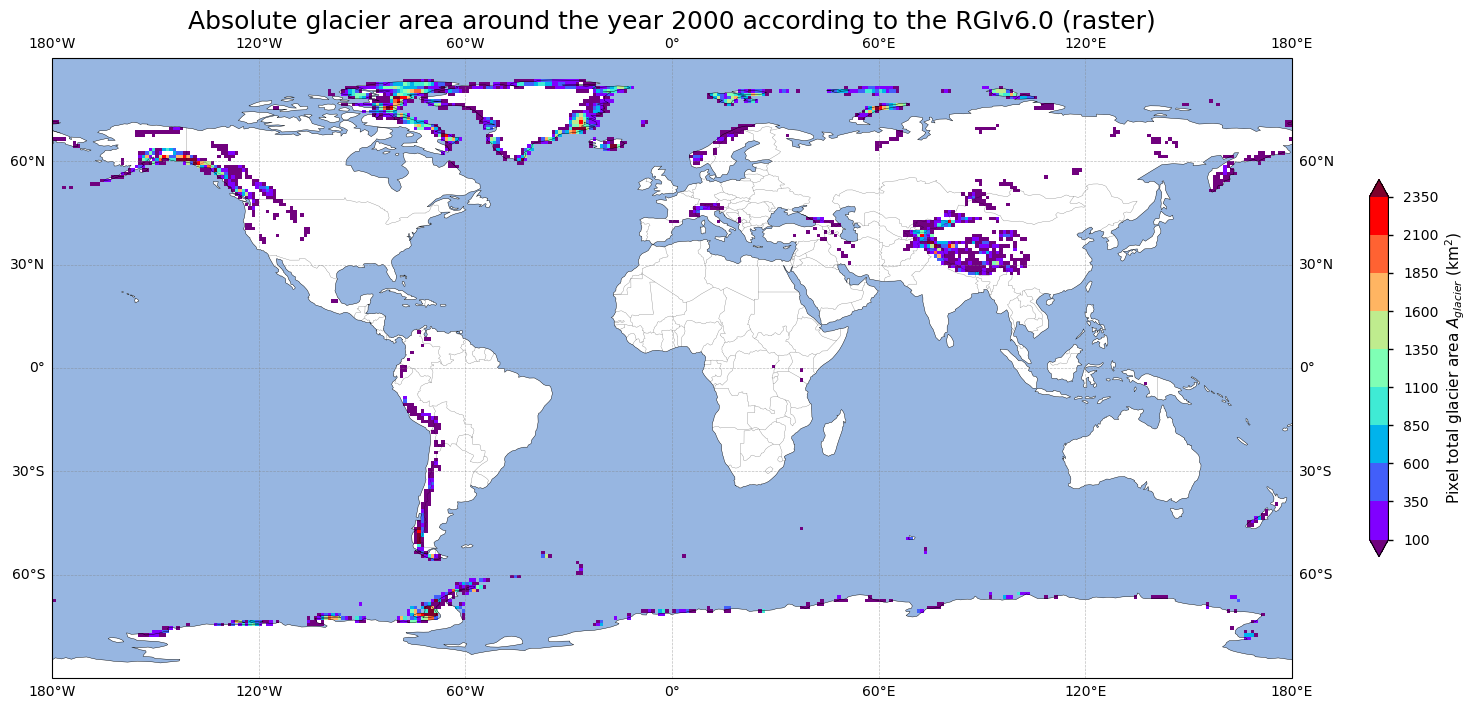

In [40]:
# Plot the gridded data
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
im=ax.pcolormesh(df2["longitude"].values, df2["latitude"].values, (((df2["Glacier_area"].values)/100)*df2["Surface_area"].values), transform=ccrs.PlateCarree(),  cmap = mpl.cm.rainbow, norm = mpl.colors.BoundaryNorm(range(100, 2600, 250), mpl.cm.rainbow.N))
fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Pixel total glacier area $A_{glacier}$ (km$^2$)')
plt.title('Absolute glacier area around the year 2000 according to the RGIv6.0 (raster)',fontsize=18)
plt.show()

*<center>Figure 2. Spatial distribution of the absolute glacier area in the raster version of the glacier extent dataset.</center>*

In order to compare this number with the vector version of the dataset, we turn to the vector format in the section below.

### Spatial distribution of glaciers and glacier area in the vector version of the dataset

Let us now inspect the vector product of the same dataset. We therefore plot the polygons (that each represent the outline of an individual glacier) as data points across the globe. Here, data are not aggregated in pixels but values thus represent the glacier area of individual glaciers. This results in the following:

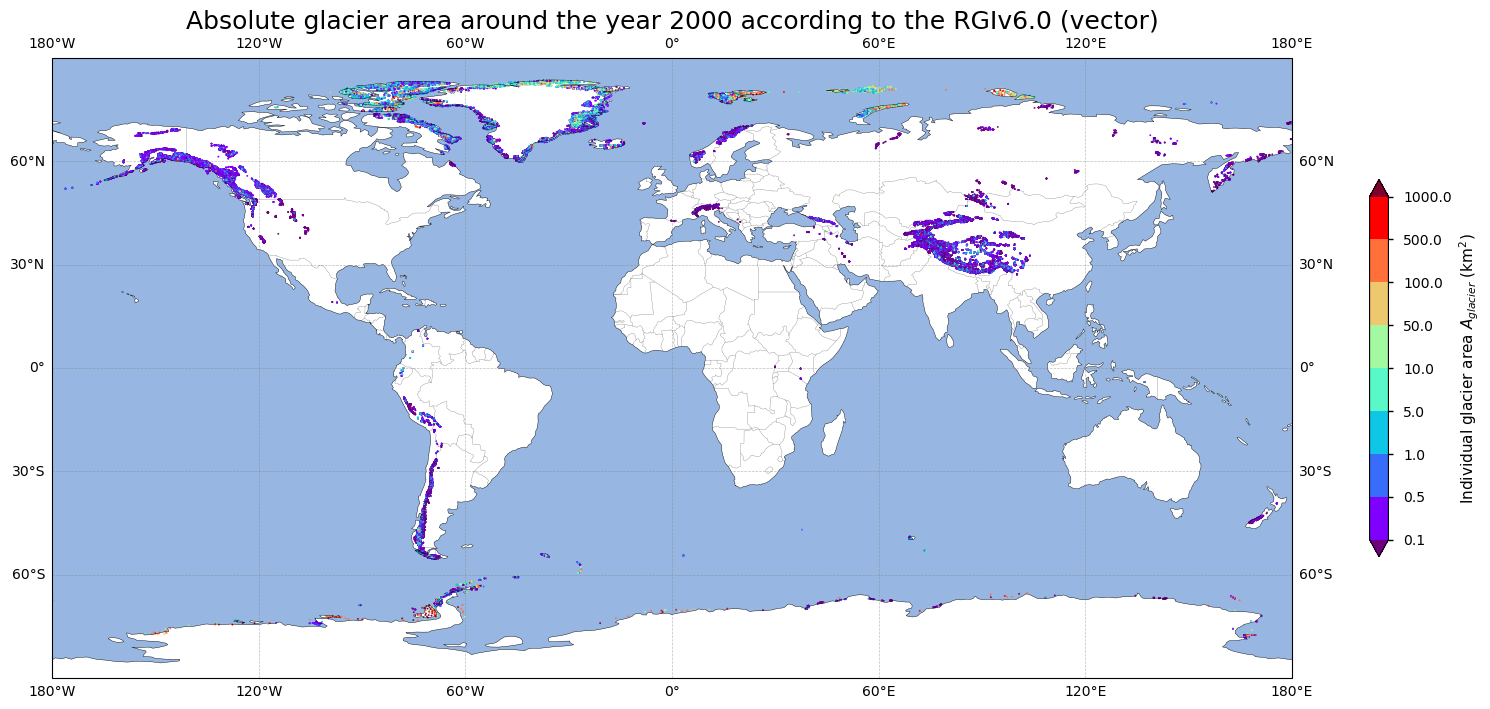

In [41]:
# Plot the gridded data
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
cmap = mpl.cm.rainbow
norm = mpl.colors.BoundaryNorm((0.1,0.5,1,5,10,50,100,500,1000), cmap.N)
sc = ax.scatter(gdf['CENLON'], gdf['CENLAT'], c=gdf['AREA'], cmap=cmap, norm=norm, s=1, transform=ccrs.PlateCarree())
fig.colorbar(sc, ax=ax, extend='both', shrink=0.49, label='Individual glacier area $A_{glacier}$ (km$^2$)')
plt.title('Absolute glacier area around the year 2000 according to the RGIv6.0 (vector)',fontsize=18)
plt.show()

*<center>Figure 3. Spatial distribution of individual glaciers and their area in the vector version of the glacier extent dataset.</center>*

The geographical distribution of glaciers is similar to that of the raster product, although the vector product allows for more detailed and glacier-specific analysis. However, due to the different representation, the above two maps do not allow for an easy quantitative comparison of the glacier area between the two versions of the dataset. Let us therefore get the statistics of the vector version of the glacier extent data:

In [42]:
# Print relevant data
print( 
    f"A total number of {len(gdf)} glaciers is present in the dataset, "
    f"covering a total surface area of {gdf['AREA'].sum():.2f} km²."
)

A total number of 216429 glaciers is present in the dataset, covering a total surface area of 746088.28 km².


This already reveals a difference between both data formats. With the above information in mind, we can now further quantify the total regional (according to the 19 RGI regions) glacier area and compare the values between the vector and raster version of the dataset more in-depth.

### Regional and global comparison of the vector and raster product

This section presents a regional and global comparison of glacier areas derived from vector and raster data products of the glacier extent data from the Randolph Glacier Inventory version 6.0 (RGIv6.0). In doing so, discrepancies and agreements between the two data formats are analyzed, providing further insights into their consistency and usability for climatological and hydrological applications, such as water resource management. We first quantify the difference of the global total glacier area between both data formats:

$
\Delta A_{\text{glacier}}^{\text{global}}
$
[km$^2$]
$
= \sum\limits^{x,y} A_{\text{glacier}}^{\text{raster}} - \sum\limits^n A_{\text{glacier}}^{\text{vector}}
$

with $x,y$ all glacier-covered pixels in the raster product and $n$ the total amount of individual glaciers in the vector product. 

This results in:

In [43]:
# Calculate the total glacier area from the raster product
total_glacier_area_raster = np.nansum(((df2['Glacier_area'].values) / 100) * df2['Surface_area'].values)
# Calculate the total glacier area from the vector product
total_glacier_area_vector = gdf['AREA'].sum()
# Print the difference
print(
    f"The difference of the total global glacier area between the raster and the vector product is "
    f"{abs(total_glacier_area_raster - total_glacier_area_vector):.2f} km²."
)

The difference of the total global glacier area between the raster and the vector product is 14260.01 km².


Let us analyse this regionally and check where the most significant differences are situated. We therefore first mask the vector data for the different RGI regions:

In [44]:
# Get the total regional glacier area from the vector product
gdf["region"] = gdf["RGIID"].str[6:8].astype(int)
grouped = gdf[["AREA", "region"]].groupby("region")
total_area = (grouped["AREA"].sum())

# Get the total regional area from the raster product
regions = gdf["RGIID"].str[6:8].astype(int)
da = regions.to_xarray().assign_coords(
    lon=gdf["CENLON"].to_xarray(),
    lat=gdf["CENLAT"].to_xarray(),
)
regridder = xe.Regridder(da, df2, locstream_in=True, method="nearest_s2d")
mask_2d = regridder(da)
mask = xr.concat(
    [(mask_2d == region).expand_dims(region=[region]) for region in regions.unique()],
    "region",
)
df3 = df2.where(mask)
total_glacier_area_all_regions = (((df3["Glacier_area"] / 100) * df3["Surface_area"]).sum(dim=['latitude', 'longitude']))

Now we can finally plot the quantified regional differences of the glacier area between the vector and raster version of the data:

$
\Delta A_{\text{glacier}}^{\text{region}}
$
[km$^2$]
$
= \sum\limits^{x,y \in \text{region}} A_{\text{glacier}}^{\text{raster}} - \sum\limits^{n\in \text{region}} A_{\text{glacier}}^{\text{vector}}
$

or in percentage difference:

$
\Delta A_{\text{glacier}}^{\text{region}}
$
[%]
$
\left|\dfrac {100 * \left(\sum\limits^{x,y \in \text{region}} A_{\text{glacier}}^{\text{raster}} - \sum\limits^{n \in \text{region}} A_{\text{glacier}}^{\text{vector}}\right)}{\sum\limits^{n \in \text{region}} A_{\text{glacier}}^{\text{vector}}}\right|
$

with $x,y$ all glacier-covered pixels in the raster product in a certain RGI region and $n$ the total amount of individual glaciers in the vector product in a certain RGI region. 

This results in the following:

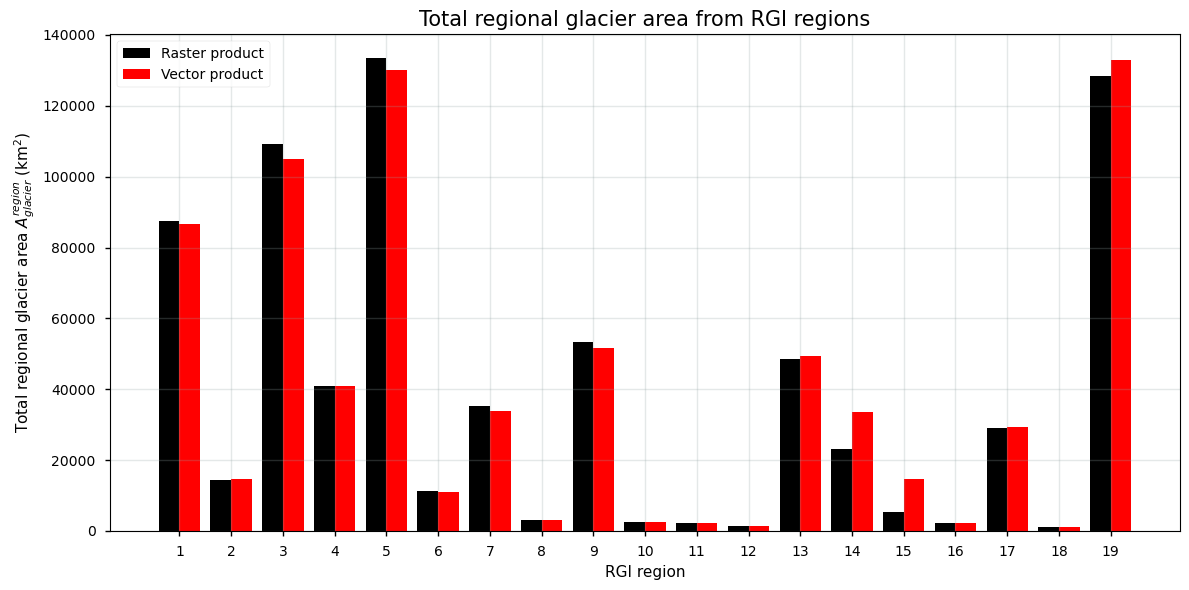

In [45]:
# Define regions and data
regions = np.arange(1, len(total_glacier_area_all_regions) + 1)  # Regions 1 to max(region)
raster_values = total_glacier_area_all_regions  # Raster product values
vector_values = total_area.values  # Vector product values
# Define bar width and positions
bar_width = 0.4
r1 = regions - bar_width / 2  # Positions for raster product bars
r2 = regions + bar_width / 2  # Positions for vector product bars
# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(r1, raster_values, width=bar_width, color='black', label='Raster product')
plt.bar(r2, vector_values, width=bar_width, color='red', label='Vector product')
# Add labels, title, and legend
plt.xlabel("RGI region")
plt.ylabel("Total regional glacier area $A^{region}_{glacier}$ (km$^{2}$)")
plt.title("Total regional glacier area from RGI regions", fontsize=15)
plt.xticks(regions)  # Set x-ticks to region numbers
plt.legend()
# Show grid and plot
plt.grid(color='#95a5a6', linestyle='-', alpha=0.25)
plt.tight_layout()
plt.show()

*<center>Figure 4. Regional comparison of the total absolute glacier area between the vector and raster version of the glacier extent dataset.</center>*

And to express it as a percentage difference:

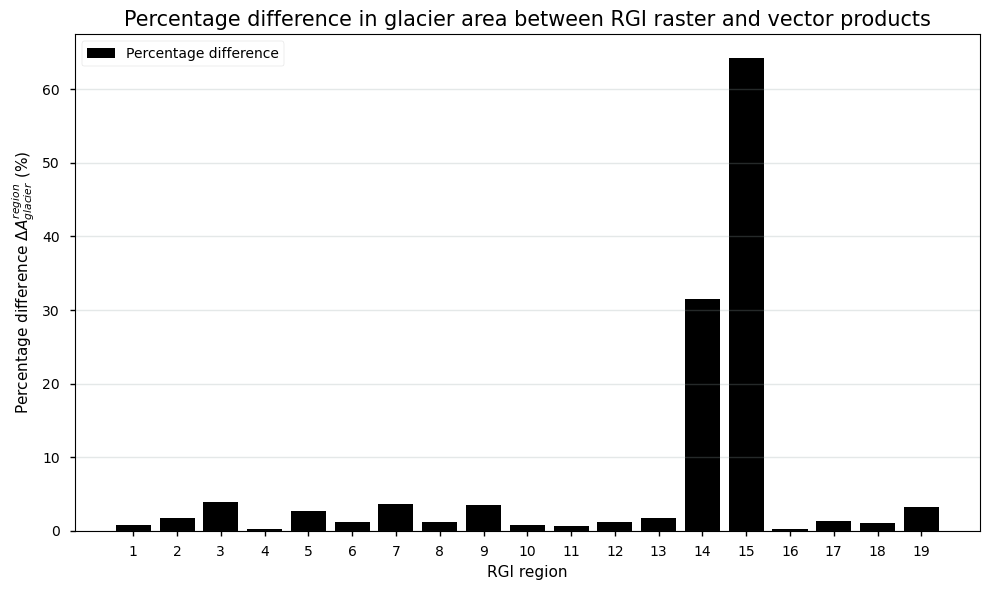

In [46]:
# Calculate the differences
differences = total_glacier_area_all_regions - total_area
percentage_differences = (100 * differences) / total_area
# Define regions
regions = np.arange(1, len(total_area) + 1)  # Generate regions as integers (1 to max)
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(regions, abs(percentage_differences), color='black', label="Percentage difference")
# Add labels, title, and grid
plt.xlabel("RGI region")
plt.ylabel("Percentage difference $\Delta A_{{glacier}}^{{region}}$ (%)")
plt.title("Percentage difference in glacier area between RGI raster and vector products", fontsize=15)
plt.grid(color='#95a5a6', linestyle='-', alpha=0.25, axis='y')  # Add grid only for y-axis
plt.xticks(regions)  # Ensure x-ticks match region numbers
plt.legend(loc="upper left")
# Show the plot
plt.tight_layout()
plt.show()

*Figure 5. Regional comparison of the percentage difference of glacier areas between the vector and raster version of the glacier extent dataset.*

The figures above compare the total regional glacier area from RGI regions using raster and vector products and shows the percentage difference between these data formats. The left plot indicates that, while the vector product generally aligns with the raster product, significant discrepancies are observed in especially RGI regions 14 and 15 (South Asia West and South Asia East), where the vector product shows notably higher absolute glacier areas. The right plot highlights that most regions exhibit low percentage differences, suggesting good agreement, except for regions 14 and 15, which show a high percentage difference. These discrepancies point to potential issues in data resolution or processing, emphasizing the need for careful evaluation of glacier areas in these regions. Let us also have these numbers quantified by text:

In [31]:
# Print values
for i, (value,perc) in enumerate(zip(differences,percentage_differences)):
    print(f"The glacier surface area in RGI region {i+1:>2} in the raster version "
          f"is {'under' if value < 0 else 'over':>5}estimated "
          f"by {np.abs(value):.2f} {'km²'} or {abs(perc):.2f}% when compared to the vector product.")

The glacier surface area in RGI region  1 in the raster version is  overestimated by 739.63 km² or 0.85% when compared to the vector product.
The glacier surface area in RGI region  2 in the raster version is underestimated by 259.24 km² or 1.78% when compared to the vector product.
The glacier surface area in RGI region  3 in the raster version is  overestimated by 4105.85 km² or 3.91% when compared to the vector product.
The glacier surface area in RGI region  4 in the raster version is  overestimated by 90.07 km² or 0.22% when compared to the vector product.
The glacier surface area in RGI region  5 in the raster version is  overestimated by 3437.81 km² or 2.64% when compared to the vector product.
The glacier surface area in RGI region  6 in the raster version is  overestimated by 129.80 km² or 1.17% when compared to the vector product.
The glacier surface area in RGI region  7 in the raster version is  overestimated by 1221.03 km² or 3.60% when compared to the vector product.
The 

The comparison between the raster and vector products of glacier area reveals varying degrees of overestimation and underestimation across different RGI regions when both data formats are compared to one another. Most regions show minor discrepancies, with the raster product generally under or overestimating glacier areas by small percentages. Notably, significant underestimations in RGI regions 14 and 15 exist. 

Potential sources of error and uncertainty for the glacier extent data, that could have contributed to the discrepancy between the raster and vector data, include [[3](https://www.cambridge.org/core/journals/journal-of-glaciology/article/new-global-gridded-glacier-dataset-based-on-the-randolph-glacier-inventory-version-60/621E15FFA80C8B0612146022A7197AC5), [4](https://www.cambridge.org/core/journals/annals-of-glaciology/article/on-the-accuracy-of-glacier-outlines-derived-from-remotesensing-data/D9EF9B9A26CEF34970C4F4924C19CE93)]: 
- Potential errors in data processing or classification: generating raster data often involves interpolation, reprocessing steps and resampling, which can introduce errors or artefacts that are not present in vector data.
- Data version mismatches: the data collection times or product version to convert vector data to raster data might differ, leading to discrepancies due to changes in glacier extents over different data versions.

### Implications for use of the data for water resource management purposes at various spatial scales

The discrepancies and inconsistency of the calculated glacier area between the raster and vector versions of the Randolph Glacier Inventory (RGIv6.0) data, especially in the Himalayan region, have been documented before [[3](https://www.cambridge.org/core/journals/journal-of-glaciology/article/new-global-gridded-glacier-dataset-based-on-the-randolph-glacier-inventory-version-60/621E15FFA80C8B0612146022A7197AC5)] and can have significant implications for water resource management across various spatial scales. Accurate glacier area data are namely crucial for understanding glacier contributions to water supplies, especially in regions where glaciers play a key role in the hydrological cycle (such as the Himalaya). 

For assessments of individual glaciers, the vector version of the data, with its polygon outlines, is particularly well-suited. The high level of detail of individual glacier outlines is crucial for applications such as local water supply management, hazard assessment, and other scientific research [[1](https://www.glims.org/RGI/randolph60.html), [2](https://www.cambridge.org/core/journals/journal-of-glaciology/article/randolph-glacier-inventory-a-globally-complete-inventory-of-glaciers/730D4CC76E0E3EC1832FA3F4D90691CE)]. It also allows for more easy validation, for example using high-resolution satellite data. On a regional scale, managing water resources in entire basins or watersheds can benefit from both raster and vector data. Raster data provide a broader overview and facilitate the integration of glacier data into larger models. However, especially the significant underestimations of glacier areas in regions 14 and 15 highlight the need for careful validation and possible correction to improve accuracy. Over or underestimation of the absolute glacier area and extent in certain regions may bias water balance models and lead to misjudgments of glacier contributions to critical water systems, particularly in regions dependent on glacier-fed rivers. Notably, RGI regions 14 and 15 show significant discrepancies between the two data formats, which must be addressed to avoid inadequate water management strategies. For larger-scale applications, such as global hydrological assessments, raster data are typically more practical due to its grid format, which allows for easier integration with other global datasets. These gridded RGI data are, however, presented as fractional glacier area data within a certain pixel (without a provided indication of the absolute surface area of the grid cell). Users are therefore advised to compare the glacier area data of the region(s) (or individual glacier) of interest with other reliable glacier datasets (or local glacier inventories) and remote sensing data to validate and cross-check them with the RGI data.

Both data formats furthermore share broader limitations, including potential low-resolution source data, digitization errors, and challenges in identifying glacier areas due to factors like supraglacial debris, shadows, and cloud cover [[4](https://www.cambridge.org/core/journals/annals-of-glaciology/article/on-the-accuracy-of-glacier-outlines-derived-from-remotesensing-data/D9EF9B9A26CEF34970C4F4924C19CE93)]. These issues are particularly pronounced in regions such as High Mountain Asia and the Caucasus, where debris cover leads to underestimation of glacier areas. Additionally, inconsistencies in glacier definitions, exclusion of smaller ice bodies, and varied digitization dates further complicate the dataset's credibility. Users are advised to validate RGI data against other datasets or remote sensing-derived information, especially for regions with debris cover, small glaciers (i.e. relative errors are known to be higher for smaller glaciers due to their larger outline-to-area ratio [[2](https://www.cambridge.org/core/journals/journal-of-glaciology/article/randolph-glacier-inventory-a-globally-complete-inventory-of-glaciers/730D4CC76E0E3EC1832FA3F4D90691CE)]), or the peripheral glaciers of Greenland and Antarctica. A last important sidenote is the fact that data cannot be used for temporal glacier area change or climate change impact assessment (it is a single snapshot in time). It is, for example, not possible to use the data for peak water discharge determination, as this would require (spatio-)temporal glacier area changes [[5](https://www.nature.com/articles/s41558-017-0049-x)].

## ℹ️ If you want to know more

### Key resources

- [Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview)
- [Documentation on the CDS](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/display/CKB/Glacier+Area)
- [Copernicus climate change indicators: glaciers](https://climate.copernicus.eu/climate-indicators/glaciers)
- [RGI website from GLIMS](https://www.glims.org/RGI/) (Global Land Ice Measurements from Space)
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control` prepared by [BOpen](https://www.bopen.eu).

### References

- [[1](https://www.glims.org/RGI/randolph60.html)] RGI Consortium (2017). Randolph Glacier Inventory – A Dataset of Global Glacier Outlines: Version 6.0: Technical Report, Global Land Ice Measurements from Space, Colorado, USA. Digital Media. doi: 10.7265/N5-RGI-60.

- [[2](https://www.cambridge.org/core/journals/journal-of-glaciology/article/randolph-glacier-inventory-a-globally-complete-inventory-of-glaciers/730D4CC76E0E3EC1832FA3F4D90691CE)] Pfeffer, W. T., Arendt, A. A., Bliss, A., Bolch, T., Cogley, J. G., Gardner, A. S., Hagen, J. O., Hock, R., Kaser, G., Kienholz, C., Miles, E. S., Moholdt, G., Mölg, N., Paul, F., Radić, V., Rastner, P., Raup, B. H., Rich, J., Sharp, M. J., and Glasser, N. (2014). The Randolph Glacier Inventory: A globally complete inventory of glaciers, Journal of Glaciology, 60(221), 537-552. doi: 10.3189/2014JoG13J176.

- [[3](https://www.cambridge.org/core/journals/journal-of-glaciology/article/new-global-gridded-glacier-dataset-based-on-the-randolph-glacier-inventory-version-60/621E15FFA80C8B0612146022A7197AC5)] Li, Y. J., Li, F., Shangguan, D. H., Ding, Y. J. (2021). A New Global Gridded Glacier Dataset Based on the Randolph Glacier Inventory Version 6.0. Journal of Glaciology, 67 (2021), 773–76. doi: 10.1017/jog.2021.28.

- [[4](https://www.cambridge.org/core/journals/annals-of-glaciology/article/on-the-accuracy-of-glacier-outlines-derived-from-remotesensing-data/D9EF9B9A26CEF34970C4F4924C19CE93)] Paul, F., Barrand, N. E., Baumann, S., Berthier, E., Bolch, T., Casey, K., Frey, H., Joshi, S. P., Konovalov, V., Le Bris, R., Mölg, N., Nosenko, G., Nuth, C., Pope, A., Racoviteanu, A., Rastner, P., Raup, B., Scharrer, K., Steffen, S., and Winsvold, S. (2013). On the Accuracy of Glacier Outlines Derived from Remote-Sensing Data. Annals of Glaciology, 54(63), 171–82. doi: 10.3189/2013AoG63A296.

- [[5](https://www.nature.com/articles/s41558-017-0049-x)] Huss, M., and Hock, R. (2018). Global-scale hydrological response to future glacier mass loss, Nature Climate Change, 8, 135–140 (2018), doi: 10.1038/s41558-017-0049-x.